In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import io
from numpy import array, argmax, random, take
import pandas as pd

import torchtext
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn import (TransformerEncoder, TransformerDecoder,TransformerEncoderLayer, TransformerDecoderLayer)
#from torchtext.legacy.vocab import vocab
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset



In [2]:
train_path_en = "train.lc.norm.tok.en"
train_path_de = "train.lc.norm.tok.de"
test_path_en = "test_2017_flickr.lc.norm.tok.en"
test_path_de = "test_2017_flickr.lc.norm.tok.de"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
with open(train_path_en) as en_raw_train:
    en_train_parsed = en_raw_train.readlines()
with open(train_path_de) as de_raw_train:
    de_train_parsed = de_raw_train.readlines()
with open(test_path_en) as en_raw_test:
    en_test_parsed = en_raw_test.readlines()
with open(test_path_de) as de_raw_test:
    de_test_parsed = de_raw_test.readlines()

In [5]:
print(len(en_train_parsed))
print(len(de_train_parsed))
print(len(en_test_parsed))
print(len(de_test_parsed))

29000
29000
1000
1000


In [6]:
for i in range(5):
    print('German', de_train_parsed[i].strip())
    print('English:', en_train_parsed[i].strip())
    

German zwei junge weiße männer sind im freien in der nähe vieler büsche .
English: two young , white males are outside near many bushes .
German mehrere männer mit schutzhelmen bedienen ein antriebsradsystem .
English: several men in hard hats are operating a giant pulley system .
German ein kleines mädchen klettert in ein spielhaus aus holz .
English: a little girl climbing into a wooden playhouse .
German ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster .
English: a man in a blue shirt is standing on a ladder cleaning a window .
German zwei männer stehen am herd und bereiten essen zu .
English: two men are at the stove preparing food .


In [7]:
from sklearn.model_selection import train_test_split
de_train, de_val, en_train, en_val = train_test_split(de_train_parsed,en_train_parsed, 
                                                         test_size=0.1, random_state = 42)

In [8]:
de_train[:10]

['ein paar lässt den anblick eines städtischen platz bei sonnenuntergang auf sich wirken .\n',
 'ein mann spielt neben einem schlagzeuger ein instrument .\n',
 'ein hund watet durch wasser .\n',
 'ein sitzender und ein stehender mann in anzügen diskutieren miteinander , während sie auf ein öffentliches transportmittel warten .\n',
 'ein mann spielt vor einem großen schild gitarre , während hinter ihm ein anderer mann schlagzeug spielt .\n',
 'eine große menschenmenge steht vor einem belebten gebäude .\n',
 'einige menschen essen in einem food-court .\n',
 'ein junges asiatisches mädchen in einem trägerlosen oberteil hält ihre kamera von sich weg , um ein foto mit ihrer freundin aufzunehmen , die das peace-zeichen macht .\n',
 'eine frau in einem langen braunen mantel versucht , besen an zwei männer zu verkaufen .\n',
 'der mann trägt einen weißen hut und posiert mit einer blonden frau und einer schwarzhaarigen frau .\n']

In [9]:
en_train[:10]

['a couple takes in the view of a town square at sunset .\n',
 'a man plays an instrument next to a drummer .\n',
 'a dog wading into the water\n',
 'two men in suits , one sitting and one standing , are having a discussion as they wait for public transportation .\n',
 'a man plays guitar in front of a large sign , with another man playing drums behind him .\n',
 'a large crowd standing in front of a busy building .\n',
 'some people are eating at a food court .\n',
 'a young asian girl in a tube top holds out her camera to get a picture with her friend who is making the peace sign .\n',
 'a woman in a long brown coat tries to cell brooms to two men .\n',
 'the man wears a white hat and poses with a blond woman and a black-haired woman .\n']

# Text preprocessing

In [10]:
en_train = [sent.strip().split(" ") for sent in en_train] 
en_test = [sent.strip().split(" ") for sent in en_test_parsed]

de_train = [sent.strip().split(" ") for sent in de_train]
de_test = [sent.strip().split(" ") for sent in de_test_parsed]

In [11]:
en_index2word = ["<PAD>", "<SOS>", "<EOS>"]
de_index2word = ["<PAD>", "<SOS>", "<EOS>"]

for data in [en_train, en_test, en_val]:
    for i in data:
        for token in i:
            if token not in en_index2word:
                en_index2word.append(token)

en_index2word[:10]

['<PAD>', '<SOS>', '<EOS>', 'a', 'couple', 'takes', 'in', 'the', 'view', 'of']

In [12]:
for data in [de_train, de_test, de_val]:
    for i in data:
        for token in i:
            if token not in de_index2word:
                de_index2word.append(token)
                
de_index2word[:10]

['<PAD>',
 '<SOS>',
 '<EOS>',
 'ein',
 'paar',
 'lässt',
 'den',
 'anblick',
 'eines',
 'städtischen']

In [13]:
en_word2index = {t: index for index, t in enumerate(en_index2word)}
de_word2index = {t: index for index, t in enumerate(de_index2word)}

In [14]:
en_len = sum([len(i) for i in en_train])/len(en_train)
de_len = sum([len(i) for i in de_train])/len(de_train)

In [15]:
print('Mean length of english sentences', en_len)
print('Mean length of german sentences', de_len)

Mean length of english sentences 13.009386973180076
Mean length of german sentences 12.427394636015325


In [16]:
de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [17]:
from sklearn.model_selection import train_test_split
de_train, de_val, en_train, en_val = train_test_split(de_train_parsed,en_train_parsed, 
                                                         test_size=0.1, random_state = 42)

In [18]:
def build_vocab(f, tokenizer):
    counter = Counter()
    
    for i in f:
        counter.update(tokenizer(str(i)))
    print(counter)
    vocab1 = vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    vocab1.set_default_index(vocab1['<unk>'])
    return vocab1

de_vocab = build_vocab(de_train, de_tokenizer)
en_vocab = build_vocab(en_train, en_tokenizer)

Counter({'\n': 26100, '.': 25938, 'ein': 17001, 'einem': 12316, 'in': 10688, 'eine': 8929, 'und': 8045, ',': 8044, 'mit': 7968, 'auf': 7869, 'mann': 7027, 'einer': 6091, 'der': 4455, 'frau': 3779, 'die': 3539, 'zwei': 3485, 'einen': 3096, 'im': 2799, 'an': 2735, 'von': 2108, 'sich': 2031, 'dem': 1928, 'mädchen': 1895, 'junge': 1890, 'vor': 1736, 'zu': 1716, 'steht': 1611, 'männer': 1473, 'sitzt': 1462, 'hund': 1432, 'den': 1422, 'straße': 1270, 'während': 1265, 'hält': 1197, 'gruppe': 1187, 'spielt': 1179, 'das': 1151, 'hemd': 1088, 'personen': 1021, 'über': 998, 'drei': 959, 'eines': 947, 'blauen': 899, 'frauen': 893, 'neben': 880, 'kind': 873, 'weißen': 867, 'ist': 866, 'roten': 845, 'spielen': 837, 'sitzen': 824, 'stehen': 822, 'aus': 815, 'menschen': 813, 'am': 805, 'durch': 791, 'bei': 789, 'geht': 776, 'trägt': 761, 'fährt': 743, 'wasser': 731, 'kinder': 713, 'um': 708, 'kleines': 682, 'person': 677, 'macht': 673, 'springt': 642, 'kleiner': 638, 'schwarzen': 631, 'entlang': 608, 

Counter({'a': 44224, '\n': 26100, '.': 24874, 'in': 13396, 'the': 9849, 'on': 7238, 'man': 6996, 'is': 6809, 'and': 6638, 'of': 6136, 'with': 5608, 'woman': 3585, ',': 3553, 'two': 3498, 'are': 3304, 'to': 2804, 'people': 2782, 'at': 2607, 'an': 2596, 'wearing': 2367, 'shirt': 2077, 'young': 2058, 'white': 2011, 'black': 1815, 'his': 1791, 'while': 1757, 'blue': 1716, 'red': 1563, 'men': 1559, 'sitting': 1554, 'boy': 1543, 'girl': 1539, 'dog': 1495, 'standing': 1466, 'playing': 1443, 'group': 1377, 'street': 1296, 'down': 1259, 'walking': 1239, '-': 1222, 'front': 1142, 'her': 1129, 'holding': 1127, 'one': 966, 'water': 947, 'by': 944, 'three': 934, 'women': 890, 'up': 844, 'little': 836, 'green': 833, 'for': 818, 'child': 818, 'outside': 788, 'as': 778, 'looking': 778, 'large': 756, '&': 720, 'brown': 713, 'through': 705, 'yellow': 704, 'children': 688, 'person': 671, 'hat': 659, 'their': 650, 'from': 650, 'into': 639, 'ball': 636, 'small': 599, 'next': 597, 'other': 597, 'dressed': 5

In [19]:
def data_process(german, english, de_vocab, en_vocab):
    result = []
    for (raw_de, raw_en) in zip(german, english):
        de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de.rstrip("n"))],
        dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en.rstrip("n"))],
        dtype=torch.long)
        result.append((de_tensor_, en_tensor_))
    return result


train_data = data_process(de_train, en_train, de_vocab, en_vocab)
val_data = data_process(de_val, en_val, de_vocab, en_vocab)
test_data = data_process(de_test_parsed, en_test_parsed, de_vocab, en_vocab)

train_data[:10]

[(tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18]),
  tensor([ 4,  5,  6,  7,  8,  9, 10,  4, 11, 12, 13, 14, 15, 16])),
 (tensor([ 4, 19, 20, 21, 22, 23,  4, 24, 17, 18]),
  tensor([ 4, 17, 18, 19, 20, 21, 22,  4, 23, 15, 16])),
 (tensor([ 4, 25, 26, 27, 28, 17, 18]), tensor([ 4, 24, 25, 26,  8, 27, 16])),
 (tensor([ 4, 29, 30,  4, 31, 19, 32, 33, 34, 35, 36, 37, 38, 14,  4, 39, 40, 41,
          17, 18]),
  tensor([28, 29,  7, 30, 31, 32, 33, 34, 32, 35, 31, 36, 37,  4, 38, 39, 40, 41,
          42, 43, 44, 15, 16])),
 (tensor([ 4, 19, 20, 42, 22, 43, 44, 45, 36, 37, 46, 47,  4, 48, 19, 49, 20, 17,
          18]),
  tensor([ 4, 17, 18, 45,  7, 46, 10,  4, 47, 48, 31, 49, 50, 17, 51, 52, 53, 54,
          15, 16])),
 (tensor([50, 51, 52, 53, 42, 22, 54, 55, 17, 18]),
  tensor([ 4, 47, 55, 35,  7, 46, 10,  4, 56, 57, 15, 16])),
 (tensor([56, 57, 58, 32, 22, 59, 17, 18]),
  tensor([58, 59, 36, 60, 13,  4, 61, 62, 15, 16])),
 (tensor([ 4, 60, 61, 62, 32, 22, 63, 64, 6

In [20]:
batch_size = 256
pad = de_vocab['<pad>']
bos = de_vocab['<bos>']
eos = de_vocab['<eos>']

In [21]:
# DataLoader
def generate_batch(data_batch):
    de_batch, en_batch = [], []
    for (x, y) in data_batch:
        de_batch.append(torch.cat([torch.tensor([bos]), x, torch.tensor([eos])], dim=0))
        en_batch.append(torch.cat([torch.tensor([bos]), y, torch.tensor([eos])], dim=0))
    de_batch = pad_sequence(de_batch, padding_value=pad)
    en_batch = pad_sequence(en_batch, padding_value=pad)
    return de_batch, en_batch

In [22]:
train_iter = DataLoader(train_data, batch_size=batch_size,
shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=batch_size,
shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=batch_size,
shuffle=True, collate_fn=generate_batch)

In [23]:
for x, y in train_iter:
    print(x.shape, y.shape)
    break

torch.Size([29, 256]) torch.Size([33, 256])


# Transformer Model

In [24]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(self, src_vocab_size, tgt_vocab_size, dropout = 0.1):
        
        super(Seq2SeqTransformer, self).__init__()
        
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.dropout = dropout
       
        #Encoder layers
        encoder_layer = TransformerEncoderLayer(d_model=512, nhead=8, dim_feedforward=512)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=3)
        
        #Decoder layer
        decoder_layer = TransformerDecoderLayer(d_model=512, nhead=8,dim_feedforward=512)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=3)
        
        #output layer
        self.l1 = nn.Linear(512, tgt_vocab_size)
        self.src_emb = TokenEmbedding(src_vocab_size)
        self.tgt_emb = TokenEmbedding(tgt_vocab_size)
        self.positional_encoding = PositionalEncoding()

    def forward(self, src, trg, src_mask, tgt_mask, src_padding,tgt_padding, memory_padding):
        
        #Positional encoding of source and target
        source_emb = self.positional_encoding(self.src_emb(src))
        target_emb = self.positional_encoding(self.tgt_emb(trg))
        enc_output = self.transformer_encoder(source_emb, src_mask, src_padding)
        output = self.transformer_decoder(target_emb, enc_output, tgt_mask, None, tgt_padding, memory_padding)
        return self.l1(output)

    def encode(self, src, src_mask):
        return self.transformer_encoder(self.positional_encoding(self.src_emb(src)), src_mask)

    def decode(self, tgt, enc_output, tgt_mask):
        return self.transformer_decoder(self.positional_encoding(self.tgt_emb(tgt)), enc_output, tgt_mask)

# Positional Encoder

In [36]:
def generate_square_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [37]:
# To obtain the notions of word order, the Positional encoding function is introduced to the token embedding.
class PositionalEncoding(nn.Module):
    def __init__(self, maxlen = 5000):
        super(PositionalEncoding, self).__init__()
        self.maxlen = maxlen
        
        den = torch.exp(- torch.arange(0, 512, 2) * math.log(10000) / 512)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, 512))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(0.1)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 512)
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(512)

In [38]:
def create_mask(src, tgt):
    source_len = src.shape[0]
    target_len = tgt.shape[0]
    
    source_mask = torch.zeros((source_len, source_len), device=device).type(torch.bool)
    source_padding = (src == pad).transpose(0, 1)


    target_mask = generate_square_mask(target_len)
    target_padding = (tgt == pad).transpose(0, 1)
    
    return source_mask, target_mask, source_padding, target_padding

In [39]:
source_vocab_len = len(de_vocab)
target_vocab_len = len(en_vocab)

In [40]:
batch_size = 256
epochs = 35

In [41]:
print(source_vocab_len)

17583


In [42]:
print(target_vocab_len)

9380


In [43]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = 'cpu'

In [44]:
transformer = Seq2SeqTransformer(source_vocab_len, target_vocab_len)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)



In [45]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=pad)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Training and Evaluation

In [46]:
loss_train = []
loss_val = []
for epoch in range(1, epochs+1):
    start_time = time.time()
    #print(start_time)
    transformer.train()
    losses = []
    for src, tgt in train_iter:
        src = src.to(device)
        tgt = tgt.to(device)
        tgt_input = tgt[:-1, :]
        optimizer.zero_grad()

        source_mask, target_mask, source_padding, target_padding = create_mask(src, tgt_input)

        logits = transformer(src, tgt_input, source_mask, target_mask, source_padding, target_padding, source_padding)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses.append(loss.item())
        
    train_loss = np.mean(losses)
    end_time = time.time()
    #print(end_time)
    
    #Evaluation
    transformer.eval()
    val_losses = []
    for src, tgt in valid_iter:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        source_mask, target_mask, source_padding, target_padding = create_mask(src, tgt_input)

        logits = transformer(src, tgt_input, source_mask, target_mask, source_padding, target_padding, source_padding)
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        val_losses.append(loss.item())
    
    val_loss = np.mean(val_losses)
    
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "
           f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 5.853, Val loss: 4.467, Epoch time = 448.894s
Epoch: 2, Train loss: 4.142, Val loss: 3.711, Epoch time = 399.431s
Epoch: 3, Train loss: 3.524, Val loss: 3.222, Epoch time = 404.009s
Epoch: 4, Train loss: 3.103, Val loss: 2.886, Epoch time = 408.990s
Epoch: 5, Train loss: 2.787, Val loss: 2.651, Epoch time = 397.174s
Epoch: 6, Train loss: 2.540, Val loss: 2.482, Epoch time = 373.148s
Epoch: 7, Train loss: 2.343, Val loss: 2.354, Epoch time = 313.908s
Epoch: 8, Train loss: 2.174, Val loss: 2.252, Epoch time = 283.842s
Epoch: 9, Train loss: 2.026, Val loss: 2.181, Epoch time = 288.623s
Epoch: 10, Train loss: 1.895, Val loss: 2.128, Epoch time = 294.793s
Epoch: 11, Train loss: 1.781, Val loss: 2.066, Epoch time = 288.489s
Epoch: 12, Train loss: 1.673, Val loss: 2.041, Epoch time = 284.384s
Epoch: 13, Train loss: 1.577, Val loss: 2.000, Epoch time = 310.885s
Epoch: 14, Train loss: 1.487, Val loss: 1.960, Epoch time = 333.041s
Epoch: 15, Train loss: 1.409, Val loss: 1.9

In [47]:
loss_train

[5.8531379839953255,
 4.14245103854759,
 3.5235437037898043,
 3.103235782361498,
 2.7872153380337883,
 2.540235196842867,
 2.343411786883485,
 2.1739862198923148,
 2.0263180008121564,
 1.8948778662027097,
 1.7805369566468632,
 1.672534844454597,
 1.5771220408233941,
 1.4867632973427867,
 1.408876214541641,
 1.3332603024501426,
 1.2641603864875495,
 1.198656978560429,
 1.1371252852327682,
 1.080624153801039,
 1.0285260291660534,
 0.976385719051548,
 0.9275367067140692,
 0.8829158439355738,
 0.8387513826875126,
 0.7979692062910866,
 0.7577787076725679,
 0.7196052524389005,
 0.6806113836812038,
 0.648793544255051,
 0.6155611668147293,
 0.5837133380712247,
 0.5530262227151909,
 0.5231736784472185,
 0.4961874861927593]

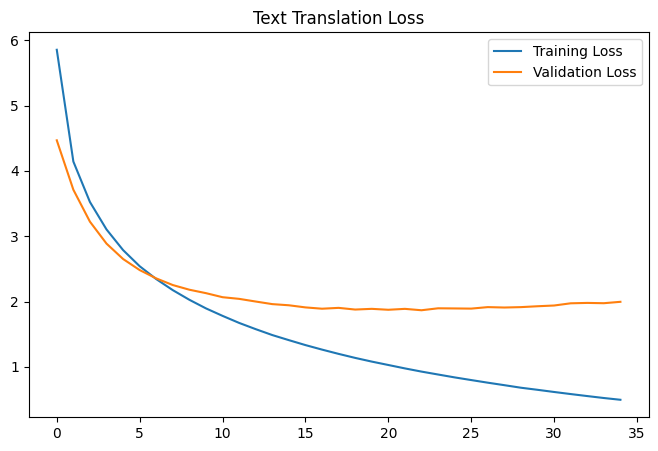

In [48]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0,35)
plt.figure(figsize = (8,5))
plt.plot(x, loss_train, label = 'Training Loss')
plt.plot(x, loss_val, label = 'Validation Loss')

plt.title('Text Translation Loss')
plt.legend()

In [52]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):

    enoder_output = model.encode(src, src_mask)
    
    op = torch.ones(1, 1).fill_(start_symbol).type(torch.long)
    
    for i in range(max_len-1):
        
        target_mask = (generate_square_mask(op.size(0)).type(torch.bool))
        out = model.decode(op, enoder_output, target_mask)
        out = out.transpose(0, 1)
        prob = model.l1(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        op = torch.cat([op,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == eos:
            break
        
    return op


In [53]:
def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
    model.eval()
    itos = tgt_vocab.get_itos()
    
    tokens = [bos] + [src_vocab.__getitem__(tok) for tok in src_tokenizer(src)] + [eos]
    num_tokens = len(tokens)
    #print(tokens)
    src = (torch.LongTensor(tokens).reshape(num_tokens, 1))
    source_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    target_token = greedy_decode(model, src, source_mask, max_len=num_tokens + 5, start_symbol=bos).flatten()
    return " ".join([itos[tok] for tok in target_token]).replace("<bos>", "").replace("<eos>", "")


In [54]:
english_text = []
org_text = []
count = 100
for i in range(len(en_test_parsed)):
    output = translate(transformer, de_test_parsed[i], de_vocab, en_vocab, de_tokenizer)
    res = output.split(' ')
    eng_text = en_test_parsed[i].strip().split(' ')
    if len(res)>1 and len(eng_text)>1:
        english_text.append(res)
        org_text.append([eng_text])
    

pip install datasets

## BLEU Score

In [55]:
from datasets import load_metric
  
bleu = load_metric("bleu")
predictions = english_text
references = org_text
print(bleu.compute(predictions=predictions, references=references))

/var/folders/vg/7d4f1ys12s17fxmrbfx48h4h0000gn/T/ipykernel_6998/1501759326.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu = load_metric("bleu")


{'bleu': 0.24691647443892484, 'precisions': [0.5093358867382533, 0.3076866603039424, 0.19261548213295301, 0.12313914465192324], 'brevity_penalty': 1.0, 'length_ratio': 1.2852496483825597, 'translation_length': 14621, 'reference_length': 11376}


In [56]:
ip_test = []
eng = []
for i in range(10):
    ip_test.append(en_test_parsed[i].strip())
    eng.append(' '.join(english_text[i]))

In [57]:
pd.set_option('display.max_colwidth', None)

In [58]:
import pandas as pd
result_df = pd.DataFrame(list(zip(ip_test, eng)), columns = ['Actual', 'Predicted'])
result_df.head(10)

,Actual,Predicted
0,a sleek yellow dog mid run on a dirt area on an obstacle course,a tan dog is vacuuming a blow - up building with some dirt way into dirt area with dirt . \n
1,a black and white photo of a dog staring ahead with a background of signs written in asian language characters .,a crowd of people are bent over at each other with a signs in the background . \n
2,an aerial landscape photo of browning grasses and a castle-like structure peaking through and a mountain landscape in the horizon .,"a low crowd of people with brown dresses , the colorful building that has been follow it with a mountainous terrain and horizon . \n"
3,a bare-chested man belts out a song during a stage performance .,a naked man with bare chest crying on stage during a performance . \n
4,a slim asian man in a long white apron and blue hat stringing pasta in a restaurant kitchen .,a slender asian man in a long white apron and blue hat pulls a restaurant in a restaurant named dahlak . \n
5,a man and a woman walking in the city,a man and a woman walking in the city . \n
6,a waterfall in a forest with many trees,a waterfall in a forest with many trees . \n
7,a bee hovering over purple and orange flowers .,a bee line above the flowers . \n
8,a calm lake surrounded by trees and rocks .,a low crowd of trees and rocks at the lake . \n
9,two people on a football field one on the ground .,two people on a soccer field one on the ground . \n
